<a href="https://colab.research.google.com/github/BalakumaranR05/Image-classification-using-FFN/blob/main/Image%20classification%20FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Model Building
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms 
from torchvision.datasets import ImageFolder


import os
import sys

# EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
# To use GPU, to make computations faster!

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
# Resizing the image and converting to Tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize the image to 64x64 pixels
    transforms.Grayscale(num_output_channels=1),  # convert the image to grayscale
    transforms.ToTensor(),  # convert the image to a PyTorch tensor
])

# Uploading the dataset from Google drive
validation_dataset = ImageFolder('/content/gdrive/MyDrive/Food_11/archive (2)/validation', transform=transform)
train_dataset = ImageFolder('/content/gdrive/MyDrive/Food_11/archive (2)/training', transform=transform)
test_dataset = ImageFolder('/content/gdrive/MyDrive/Food_11/archive (2)/evaluation', transform=transform)

In [10]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9866
    Root location: /content/gdrive/MyDrive/Food_11/archive (2)/training
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

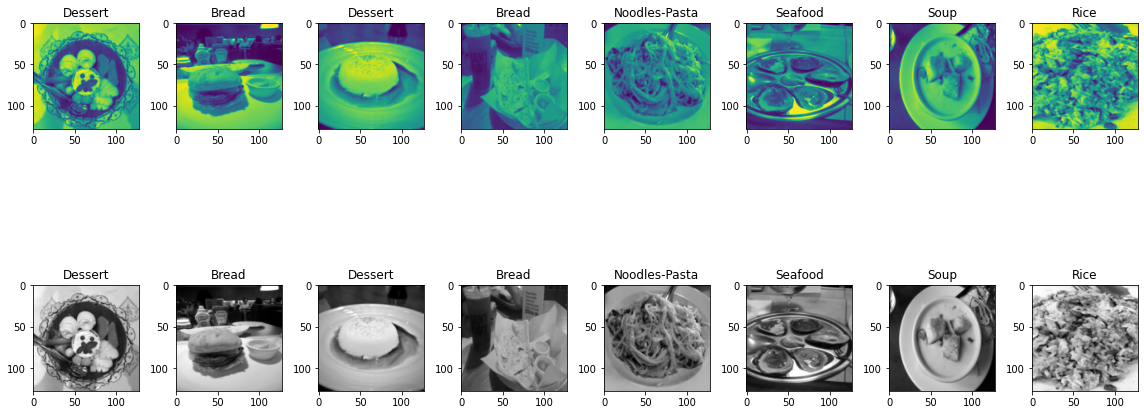

In [11]:
# To get the class_names of the images
class_names = sorted(os.listdir('/content/gdrive/MyDrive/Food_11/archive (2)/training'))

# Taking the first batch in the train_loader
batchsize = 750
train_loader  = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size = 3347) # 3347 - Total number of datapoints


images,labels = next(iter(train_loader))
fig,ax = plt.subplots(2,8,figsize=(16,10))

for i in range(8):
  ax[0,i].imshow(images[i,0,:,:])
  ax[0,i].set_title(class_names[labels[i]])
  ax[1,i].imshow(images[i,0,:,:], cmap ='gray')
  ax[1,i].set_title(class_names[labels[i]])
  plt.tight_layout()

In [12]:
images.shape, labels.shape

(torch.Size([750, 1, 128, 128]), torch.Size([750]))

In [13]:
def createNet():

    class ANNnet(nn.Module):

        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(16384,5000)

            # Hidden layers
            self.fc1 = nn.Linear(5000,1000)
            self.fc2 = nn.Linear(1000, 500)
            self.fc3 = nn.Linear(500, 100)

            # Output layer
            self.output = nn.Linear(100,len(class_names))

        def forward(self,x):

            # Flatten the input layer
            x = x.view(-1, 16384)

            x = F.relu(self.input(x))

            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))

            return self.output(x)

    # Create instance of the class
    image_net = ANNnet()

    # Loss function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(image_net.parameters(), lr = 0.05)

    return image_net, loss_func, optimizer

In [14]:
def train_net(numepochs):

  net, loss_func, optimizer = createNet()
  net.to(device)

  trainAcc = []
  testAcc = []
  losses = []

  for epochi in range(numepochs):

    batchAcc = []
    batchLoss = []
    batch_num = 1

    for X,y in train_loader:

      #Send the data to GPU
      X = X.to(device)
      y = y.to(device)

      # Foward pass
      yHat = net(X)
      loss = loss_func(yHat,y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Storing Batch loss
      batchLoss.append(loss.item())

      #Getting back from GPU
      yHat = yHat.cpu()
      y = y.cpu()

      # Computing Accuracy
      matches = torch.argmax(yHat, axis = 1) == y
      matches_num = matches.float()
      accuracy = 100 * torch.mean(matches_num)



      # Storing Batch accuracy
      batchAcc.append(accuracy)

      msg = f'Finished Epoch/ Batch {epochi,batch_num} / Total -  {numepochs,int(9855/batchsize)}'
      sys.stdout.write('\r' + msg)

      batch_num +=1
      # End of Batch Loop
    
    # Average of Batch Accuracy gives as the training Acc
    trainAcc.append(np.mean(batchAcc))

    # Average of Batch Losses gives as the losses over each epoch
    losses.append(np.mean(batchLoss))

    # Test Accuracy
    X,y = next(iter(test_loader))

    #Send the data to GPU
    X = X.to(device)
    y = y.to(device)

    # Switching off Gradient calculations
    with torch.no_grad():
      # Foward pass
      yHat = net(X)
      loss = loss_func(yHat,y)
    
    #Getting back from GPU
    yHat = yHat.cpu()
    y = y.cpu()
    
    # Appending test Accuracy
    testAcc.append(100 * torch.mean((torch.argmax(yHat,axis=1) == y).float()))

    # End of Epochs

  return trainAcc, testAcc, losses

In [ ]:
trainAcc, testAcc, losses = train_net(10)

Finished Epoch/ Batch (0, 8) / Total -  (10, 13)

In [ ]:
plt.plot(trainAcc, 'o-', label ='train')
plt.plot(testAcc,'o-', label ='test')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,20,5))
plt.ylabel('Accuracy')
plt.legend(loc = 'upper left')

NameError: ignored

In [ ]:
plt.plot(losses, 'o-', label='Losses')
plt.xlabel('Epochs')
plt.xticks(np.arange(1,20,5))
plt.ylabel('Losses')
plt.legend()
